In [1]:
import numpy as np
%load_ext autoreload
import torch
import torch.nn.functional as F
import random
import re
!pwd

/Users/magnus/repos/dl-by-doing/dev


In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
# torch.hub.download_url_to_file(url, '../data/shakespeare.txt')

In [33]:
data = open('../data/shakespeare.txt', 'r').read().splitlines()

In [34]:
data = [d for d in data if d != '']
# do not remove full stop
data = [re.sub(r'[^a-zA-Z0-9 .]', '', d) for d in data]
# data = [re.sub(r'[^a-zA-Z0-9 ]', '', d) for d in data]
data = [d.split(' ') for d in data]
# slit out "."
data = [d for d in data if len(d) > 1]
data = [item for sublist in data for item in sublist]
# make "." its own word
data = [d.split('.') for d in data]
data = [item for sublist in data for item in sublist]
# replace "" with "."
data = [d if d != '' else '.' for d in data]
# data = [item for sublist in data for item in sublist]
data = [d.lower() for d in data]
data = np.array(data)

In [35]:
data = data[:10_000]

In [36]:
# vocabulary V
vocabulary = {}

for w in data:
    if w not in vocabulary:
        vocabulary[w] = 1
    else:
        vocabulary[w] += 1

In [37]:
data[:20]

array(['first', 'citizen', 'before', 'we', 'proceed', 'any', 'further',
       'hear', 'me', 'speak', '.', 'speak', 'speak', '.', 'first',
       'citizen', 'you', 'are', 'all', 'resolved'], dtype='<U18')

In [38]:
# |V|
len(vocabulary)

2198

In [39]:
wtoi = {w:i for (i,w) in enumerate((list(vocabulary.keys())))}

In [40]:
itow = {value:key for (key,value) in wtoi.items()}

In [41]:
wtoi["."]

10

In [48]:
# build the dataset
n = 5
block_size = n - 1 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    context = [0] * block_size
    for w in words:
        ix = wtoi[w]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X[3:], Y[3:]

random.seed(42)
# random.shuffle(data)
n1 = int(0.8*len(data))
n2 = int(0.9*len(data))

Xtr, Ytr = build_dataset(data[:n1])
Xdev, Ydev = build_dataset(data[n1:n2])
Xte, Yte = build_dataset(data[n2:])

torch.Size([8000, 4]) torch.Size([8000])
torch.Size([1000, 4]) torch.Size([1000])
torch.Size([1000, 4]) torch.Size([1000])


In [49]:
for i in range(5, 10):
    print(f"{Xtr[i]} -> {Ytr[i]}")
    print(f"{[itow[x.item()] for x in Xtr[i]]} -> {itow[Ytr[i].item()]}")

tensor([4, 5, 6, 7]) -> 8
['proceed', 'any', 'further', 'hear'] -> me
tensor([5, 6, 7, 8]) -> 9
['any', 'further', 'hear', 'me'] -> speak
tensor([6, 7, 8, 9]) -> 10
['further', 'hear', 'me', 'speak'] -> .
tensor([ 7,  8,  9, 10]) -> 9
['hear', 'me', 'speak', '.'] -> speak
tensor([ 8,  9, 10,  9]) -> 9
['me', 'speak', '.', 'speak'] -> speak


In [50]:
h = 100
n = 5
m = 30

batch_size = 128

g = torch.Generator().manual_seed(42)

C = torch.randn((len(vocabulary), m), generator=g)
H = torch.randn((h, (n-1) * m), generator=g) # (h, (n-1)*m)
b = torch.randn((len(vocabulary), 1), generator=g) # (|V|, 1)
U = torch.randn((len(vocabulary), h), generator=g) # (|V|, h)
d = torch.randn((h, 1), generator=g)

parameters = [C, H, U, b, d]

for p in parameters:
    p.requires_grad = True

lri = []
lossi = []
stepi = []

for i in range(20_000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # (32, ) <> (batch_size, )

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 5) <> (batch_size, (n-1), m)
    x = emb.view((n-1)*m, -1) # (15, 32) <> ((n-1)*m, batch_size,)
    h = torch.tanh(d + H @ x) # (200, 32) <> (h, batch_size)
    logits = b + U @ h # (12823, 32) <> (|V|, batch_size)
    loss = F.cross_entropy(logits.T, Ytr[ix]) # transpose so that in expected shape: logits: (batch_size, ...), target: (batch_size)
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

    if i % 1000 == 0:
        print(loss.item())

34.49618148803711
28.148006439208984
26.385412216186523
22.354833602905273
10.000210762023926
8.00522232055664
7.104043006896973
6.340682029724121
6.911227703094482
6.829572677612305
6.374275207519531
6.566662788391113
6.168091773986816
6.226218223571777
6.269761562347412
6.253377437591553
6.223917484283447
6.80210018157959
6.4302287101745605
6.498167991638184


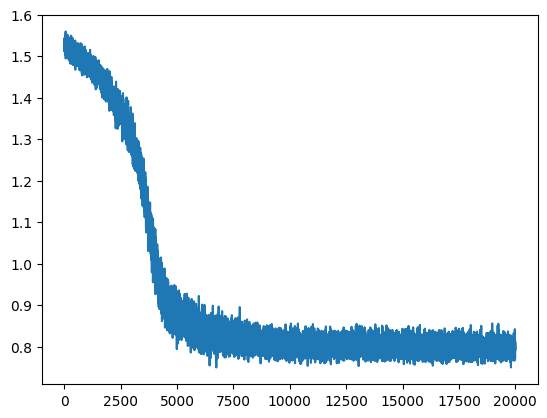

In [51]:
from matplotlib import pyplot as plt

plt.plot(stepi, lossi)

In [52]:
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        x = emb.view((n-1)*m, -1) # (15, 32) <> ((n-1)*m, batch_size,)
        h = torch.tanh(d + H @ x) # (200, 32) <> (h, batch_size)
        logits = (b + U @ h).T
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 10:
            break

    print(' '.join(itow[i] for i in out))

your be if best put first thee might nobility to how honours win general thought hospitable steed together that he we forth .
hes he ere in lets your do it troth bands when aufidius men though find when advanced neer assist chance cominius aim deliberate horns lungs ever interior acclamations virtue dear countenance awe pack from to way hereafter .
of poorest .
eat attend neighbours grain told kings blood fortnight woman state petitiond found galen body city vows doubtless outweighs brow patrician malice defend princely eer o twill tauntingly limbs speakst about gone follow too war chain lift together antiates two if success oer lookd thightheres empiricutic willing may devour even laughd make find gods city has because was shouldst sent pays issued whereof wholesome rome bolder citizen believe in the good then beholding of you you that death one we .
heaven my has power are my against whereof no this hector the goes second tis to all a ready town pray a of you dearth some .
abhorring 

In [21]:
context = [0] * block_size
context

[0, 0, 0]

In [25]:
emb = C[torch.tensor([context])]

In [26]:
x = emb.view((n-1)*m, -1) # (15, 32) <> ((n-1)*m, batch_size,)
h = torch.tanh(d + H @ x) # (200, 32) <> (h, batch_size)
logits = b + U @ h

In [27]:
logits.shape

torch.Size([2243, 1])

In [41]:
probs = F.softmax(logits.T, dim=1)

In [44]:
probs

tensor([[0.0045, 0.0033, 0.0004,  ..., 0.0002, 0.0002, 0.0001]],
       grad_fn=<SoftmaxBackward0>)

In [46]:
ix = torch.multinomial(probs, num_samples=1, generator=g).item()

In [48]:
ix

595